In [1]:
# libraries used
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# importing the merged dataset which we will only use the data from 2015-2017
data = pd.read_csv('reanalysis_merged_3hourMean.csv')

# importing the testing data set which we will only use the data from 2018
testing_data = pd.read_csv('ensembleMean_merged.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00']                    # trainig set are data from dates before 2018
test = testing_data[testing_data['time']>='2018-01-01 00:00:00']    # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

In [5]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5844))             # dates before 2017 to train
test_indices = list(range(5844, len(train)))    # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

Creating some functions in order to facilitate the modeling afterwards

In [6]:
# 1. Random forest
def optimize_rf(x_train, y_train, params_rf):
    rf=RandomForestRegressor(random_state = 10)
    rf_search = RandomizedSearchCV(rf, params_rf, cv=custom_cv, n_iter = 30)
    rf_search.fit(x_train, y_train)
    return rf_search.best_estimator_

In [7]:
# 2. Gradient boosting
def optimize_gb(x_train, y_train, params_gb):
    gb=GradientBoostingRegressor(random_state = 10)
    gb_search = RandomizedSearchCV(gb, params_gb, cv=custom_cv, n_iter = 30)
    gb_search.fit(x_train, y_train)
    return gb_search.best_estimator_

In [8]:
# 3. SVM
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

### Defining Metric Matrix

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 

Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

In [9]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF_1','GB_1','SVM_1',  # 1 means 15 components of pls
                                'RF_2','GB_2','SVM_2',  # 2 means 20 components of pls
                                'RF_3','GB_3','SVM_3']) # 3 means 25 components of pls

In [10]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

### ALL VARIABLES

In [11]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    mae = mean_absolute_error(y, y_cv)

    return (y_cv, r2, mse, rpd, mae)

In [12]:
# test with 30 components
r2s = []
mses = []
rpds = []
maes = []

xticks = np.arange(1, 30)
for n_comp in xticks:
    y_cv, r2, mse, rpd, mae = optimise_pls_cv(x_train, y_train, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    maes.append(mae)

In [13]:
# Plot the metrics
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

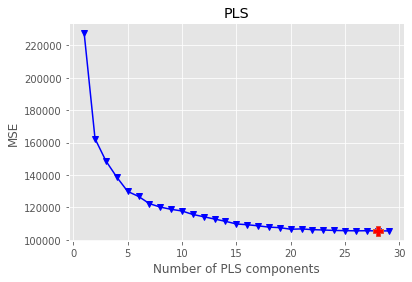

In [14]:
plot_metrics(mses, 'MSE', 'min')

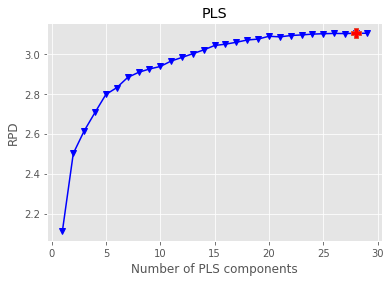

In [15]:
plot_metrics(rpds, 'RPD', 'max')

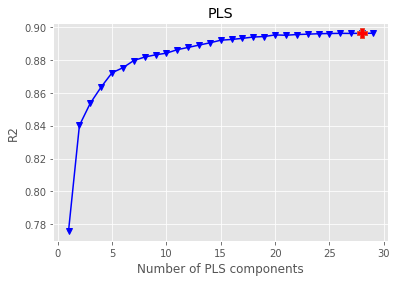

In [16]:
plot_metrics(r2s, 'R2', 'max')

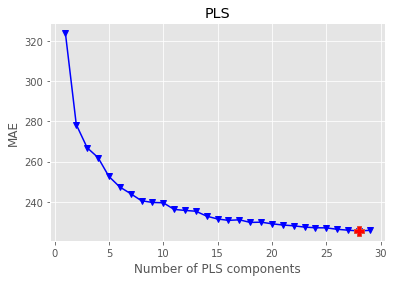

In [17]:
plot_metrics(maes, 'MAE', 'min')

In [18]:
pls1 = PLSRegression(n_components=15).fit(x_train, y_train)
x_train_1 = pls1.transform(x_train)
x_test_1 = pls1.transform(x_test)

In [19]:
pls2 = PLSRegression(n_components=20).fit(x_train, y_train)
x_train_2 = pls2.transform(x_train)
x_test_2 = pls2.transform(x_test)

In [20]:
pls3 = PLSRegression(n_components=25).fit(x_train, y_train)
x_train_3 = pls3.transform(x_train)
x_test_3 = pls3.transform(x_test)

#### 1. Random forest

In [21]:
params_rf1 = {'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(150, 280)}

rf1 = optimize_rf(x_train_1, y_train, params_rf1)
rf1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=22,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [22]:
rf1_pred_train = rf1.predict(x_train_1)
rf1_pred_test = rf1.predict(x_test_1)

metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF_1')

explained variance of training set: 0.9124107999146517
explained variance of testing set: 0.8466730026116649
maximum error of training set: 1840.512462060749
maximum error of testing set: 1961.0143709095769
mae of training set: 218.39842540873278
mae of testing set: 255.71831693817475
mse of training set: 88951.63494750134
mse of testing set: 130929.50372318404
rmse of training set: 298.2476067758153
rmse of testing set: 361.84182141259464


In [23]:
params_rf2 = {'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(150, 280)}

rf2 = optimize_rf(x_train_2, y_train, params_rf2)
rf2

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=23,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [24]:
rf2_pred_train = rf2.predict(x_train_2)
rf2_pred_test = rf2.predict(x_test_2)

metrics(y_train, rf2_pred_train, y_test, rf2_pred_test, 'RF_2')

explained variance of training set: 0.9125348521823633
explained variance of testing set: 0.8440494644229433
maximum error of training set: 1833.9311255121875
maximum error of testing set: 1961.693988131647
mae of training set: 218.40059869064876
mae of testing set: 258.6645205196483
mse of training set: 88825.72454571848
mse of testing set: 133493.74384909315
rmse of training set: 298.0364483510674
rmse of testing set: 365.3679567902653


In [25]:
params_rf3 = {'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(150, 280)}

rf3 = optimize_rf(x_train_3, y_train, params_rf3)
rf3

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=24,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=239, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [26]:
rf3_pred_train = rf3.predict(x_train_3)
rf3_pred_test = rf3.predict(x_test_3)

metrics(y_train, rf3_pred_train, y_test, rf3_pred_test, 'RF_3')

explained variance of training set: 0.9123752715399075
explained variance of testing set: 0.8442212745624498
maximum error of training set: 1803.6067266967393
maximum error of testing set: 1956.4393200844574
mae of training set: 218.46680291652004
mae of testing set: 258.6853651719124
mse of training set: 88987.75490175767
mse of testing set: 133361.33548423043
rmse of training set: 298.308154266285
rmse of testing set: 365.18671318139496


#### 2 Gradient Boosting

In [27]:
params_gb1 = {'learning_rate': loguniform(0.0001, 0.3),
             'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(180, 280)}

gb1 = optimize_gb(x_train_1, y_train, params_gb1)
gb1

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.030884847167526434,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=14,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=261, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [28]:
gb1_pred_train = gb1.predict(x_train_1)
gb1_pred_test = gb1.predict(x_test_1)

metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB_1')

explained variance of training set: 0.9592877379662096
explained variance of testing set: 0.8403218358440869
maximum error of training set: 1172.5975256693953
maximum error of testing set: 1867.7389211922768
mae of training set: 144.0519201228898
mae of testing set: 249.97414415626446
mse of training set: 41345.53420810283
mse of testing set: 138874.782828423
rmse of training set: 203.3360130623762
rmse of testing set: 372.65907050335295


In [29]:
params_gb2 = {'learning_rate': loguniform(0.0001, 0.3),
             'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(180, 280)}

gb2 = optimize_gb(x_train_2, y_train, params_gb2)
gb2

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.13186151117144698,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=22,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=180, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [30]:
gb2_pred_train = gb2.predict(x_train_2)
gb2_pred_test = gb2.predict(x_test_2)

metrics(y_train, gb2_pred_train, y_test, gb2_pred_test, 'GB_2')

explained variance of training set: 0.9708421225650257
explained variance of testing set: 0.8208933480252026
maximum error of training set: 1129.514298306026
maximum error of testing set: 1860.1049797305295
mae of training set: 121.82960011461665
mae of testing set: 271.59449658202874
mse of training set: 29611.423160983275
mse of testing set: 154448.67254587778
rmse of training set: 172.07970002584057
rmse of testing set: 392.99958339148117


In [31]:
params_gb3 = {'learning_rate': loguniform(0.0001, 0.3),
              'max_depth': sp_randint(2, 5), 
              'min_samples_leaf': sp_randint(10, 25),
              'n_estimators': sp_randint(180, 280)}

gb3 = optimize_gb(x_train_3, y_train, params_gb3)
gb3

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.17250643065590868,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=24,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=216, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [32]:
gb3_pred_train = gb3.predict(x_train_3)
gb3_pred_test = gb3.predict(x_test_3)

metrics(y_train, gb3_pred_train, y_test, gb3_pred_test, 'GB_3')

explained variance of training set: 0.9780696884705649
explained variance of testing set: 0.7947494824172459
maximum error of training set: 1076.0280229389846
maximum error of testing set: 2122.5451109400046
mae of training set: 106.19489903704176
mae of testing set: 323.78180101572786
mse of training set: 22271.43372141918
mse of testing set: 219377.71126577118
rmse of training set: 149.23616760497163
rmse of testing set: 468.3777442041532


#### 1.3 Support Vector Machine

In [33]:
params_svm1 = {'C': loguniform(10e-4, 10e+4),
               'gamma': loguniform(10e-4, 10e+1),
               'kernel': ['rbf']}

svm1 = optimize_svm(x_train_1, y_train, params_svm1)
svm1

SVR(C=11150.729362025286, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.007194019940348339, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
svm1_pred_train = svm1.predict(x_train_1)
svm1_pred_test = svm1.predict(x_test_1)

metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_1')

explained variance of training set: 0.9651521994856314
explained variance of testing set: 0.6960122671877065
maximum error of training set: 1244.7156072611313
maximum error of testing set: 2205.359863245887
mae of training set: 120.09099499484775
mae of testing set: 349.7075331038701
mse of training set: 35431.239466478735
mse of testing set: 256879.90543587736
rmse of training set: 188.23187686063892
rmse of testing set: 506.83321264088187


In [35]:
params_svm2 = {'C': loguniform(10e-4, 10e+4),
               'gamma': loguniform(10e-4, 10e+1),
               'kernel': ['rbf']}

svm2 = optimize_svm(x_train_2, y_train, params_svm2)
svm2

SVR(C=3364.6188250331543, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.005227914011003575, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
svm2_pred_train = svm2.predict(x_train_2)
svm2_pred_test = svm2.predict(x_test_2)

metrics(y_train, svm2_pred_train, y_test, svm2_pred_test, 'SVM_2')

explained variance of training set: 0.960999546499243
explained variance of testing set: 0.7076517771793965
maximum error of training set: 1386.6514314200454
maximum error of testing set: 2262.2869220677367
mae of training set: 130.77553937582167
mae of testing set: 354.7890741345751
mse of training set: 39633.074200231866
mse of testing set: 264108.3202556677
rmse of training set: 199.08057213156653
rmse of testing set: 513.9147013422245


In [37]:
params_svm3 = {'C': loguniform(10e-4, 10e+4),
               'gamma': loguniform(10e-4, 10e+1),
               'kernel': ['rbf']}

svm3 = optimize_svm(x_train_3, y_train, params_svm3)
svm3

SVR(C=4014.021813522242, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0023502296618087047, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
svm3_pred_train = svm3.predict(x_train_3)
svm3_pred_test = svm3.predict(x_test_3)

metrics(y_train, svm3_pred_train, y_test, svm3_pred_test, 'SVM_3')

explained variance of training set: 0.9571582422001869
explained variance of testing set: 0.7589689481563675
maximum error of training set: 1358.474711530398
maximum error of testing set: 2356.9979096192437
mae of training set: 139.7432147491891
mae of testing set: 356.0955197047384
mse of training set: 43555.981497176654
mse of testing set: 277089.83781459613
rmse of training set: 208.7006983629347
rmse of testing set: 526.3932349627948


In [39]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF_1,0.912411,0.846673,1840.51,1961.01,218.398,255.718,88951.6,130930,298.248,361.842
GB_1,0.959288,0.840322,1172.6,1867.74,144.052,249.974,41345.5,138875,203.336,372.659
SVM_1,0.965152,0.696012,1244.72,2205.36,120.091,349.708,35431.2,256880,188.232,506.833
RF_2,0.912535,0.844049,1833.93,1961.69,218.401,258.665,88825.7,133494,298.036,365.368
GB_2,0.970842,0.820893,1129.51,1860.1,121.83,271.594,29611.4,154449,172.08,393
SVM_2,0.961,0.707652,1386.65,2262.29,130.776,354.789,39633.1,264108,199.081,513.915
RF_3,0.912375,0.844221,1803.61,1956.44,218.467,258.685,88987.8,133361,298.308,365.187
GB_3,0.97807,0.794749,1076.03,2122.55,106.195,323.782,22271.4,219378,149.236,468.378
SVM_3,0.957158,0.758969,1358.47,2357,139.743,356.096,43556,277090,208.701,526.393
